# MNIST Handwritten Digit Classifier with Keras

A complete neural network classifier for the MNIST dataset including:

- Data loading & preprocessing
- Model architecture
- Training with callbacks
- Comprehensive metrics & visualizations


## 1. Imports


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

# Reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow version : {tf.__version__}")
print(f"Keras version      : {keras.__version__}")

TensorFlow version : 2.20.0
Keras version      : 3.13.2


## 2. Load & Explore Data


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Training images   : (60000, 28, 28)  labels: (60000,)
Test images       : (10000, 28, 28)   labels: (10000,)
Pixel range       : [0, 255]
Classes           : [0 1 2 3 4 5 6 7 8 9]


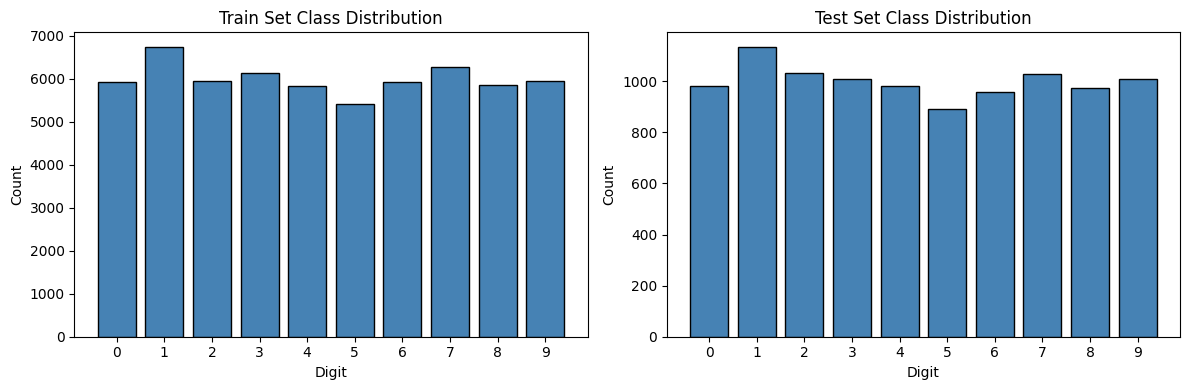

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(f"Training images   : {X_train.shape}  labels: {y_train.shape}")
print(f"Test images       : {X_test.shape}   labels: {y_test.shape}")
print(f"Pixel range       : [{X_train.min()}, {X_train.max()}]")
print(f"Classes           : {np.unique(y_train)}")

# Class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, (data, title) in zip(axes, [(y_train, "Train"), (y_test, "Test")]):
    unique, counts = np.unique(data, return_counts=True)
    ax.bar(unique, counts, color="steelblue", edgecolor="black")
    ax.set_xlabel("Digit")
    ax.set_ylabel("Count")
    ax.set_title(f"{title} Set Class Distribution")
    ax.set_xticks(unique)
plt.tight_layout()
plt.show()

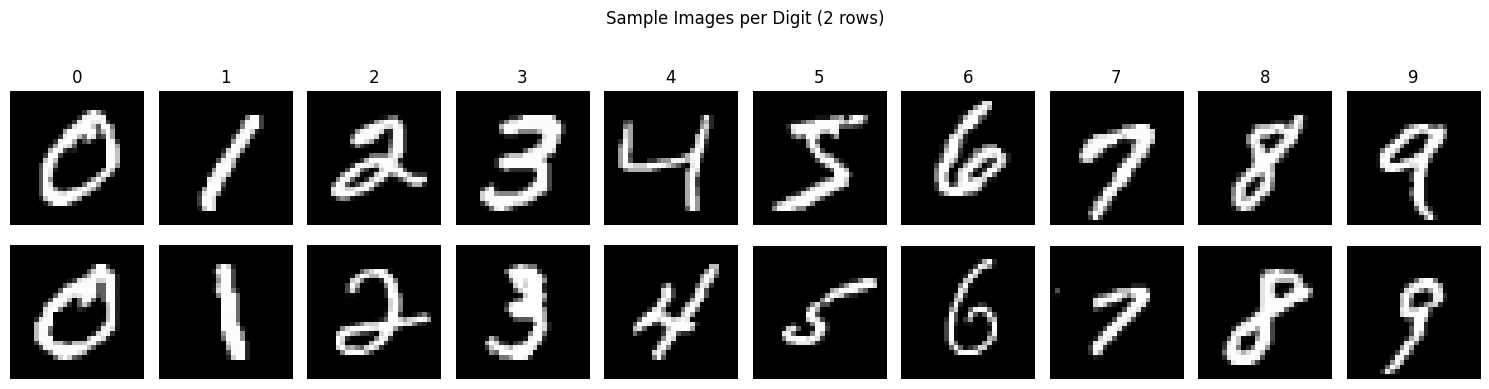

In [3]:
# Visualize sample images
fig, axes = plt.subplots(2, 10, figsize=(15, 4))
for digit in range(10):
    idx = np.where(y_train == digit)[0][0]
    axes[0, digit].imshow(X_train[idx], cmap="gray")
    axes[0, digit].set_title(str(digit))
    axes[0, digit].axis("off")
    # Second row: another sample
    idx2 = np.where(y_train == digit)[0][1]
    axes[1, digit].imshow(X_train[idx2], cmap="gray")
    axes[1, digit].axis("off")
plt.suptitle("Sample Images per Digit (2 rows)", y=1.02)
plt.tight_layout()
plt.show()

## 3. Preprocess Data


In [4]:
# Normalize to [0, 1]
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

# Flatten 28x28 → 784
X_train_flat = X_train.reshape(-1, 28 * 28)
X_test_flat = X_test.reshape(-1, 28 * 28)

# One-hot encode labels
NUM_CLASSES = 10
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

print(f"X_train_flat shape : {X_train_flat.shape}")
print(f"y_train_ohe shape  : {y_train_ohe.shape}")

X_train_flat shape : (60000, 784)
y_train_ohe shape  : (60000, 10)


## 4. Build Model


In [5]:
def build_model(input_dim: int = 784, num_classes: int = 10) -> keras.Model:
    model = keras.Sequential(
        [
            layers.Input(shape=(input_dim,), name="input"),
            layers.Dense(512, activation="relu", name="dense_1"),
            layers.BatchNormalization(name="bn_1"),
            layers.Dropout(0.3, name="dropout_1"),
            layers.Dense(256, activation="relu", name="dense_2"),
            layers.BatchNormalization(name="bn_2"),
            layers.Dropout(0.3, name="dropout_2"),
            layers.Dense(128, activation="relu", name="dense_3"),
            layers.Dropout(0.2, name="dropout_3"),
            layers.Dense(num_classes, activation="softmax", name="output"),
        ],
        name="mnist_classifier",
    )
    return model


model = build_model()
model.summary()

Model: "mnist_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 570,506 (2.18 MB)

 Trainable params: 568,970 (2.17 MB)

 Non-trainable params: 1,536 (6.00 KB)

## 5. Compile & Train


In [6]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=3, verbose=1, min_lr=1e-6
    ),
]

history = model.fit(
    X_train_flat,
    y_train_ohe,
    epochs=30,
    batch_size=128,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8995 - loss: 0.3252 - val_accuracy: 0.9692 - val_loss: 0.1006 - learning_rate: 0.0010
Epoch 2/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9537 - loss: 0.1514 - val_accuracy: 0.9777 - val_loss: 0.0756 - learning_rate: 0.0010
Epoch 3/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9645 - loss: 0.1132 - val_accuracy: 0.9773 - val_loss: 0.0699 - learning_rate: 0.0010
Epoch 4/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9702 - loss: 0.0945 - val_accuracy: 0.9798 - val_loss: 0.0674 - learning_rate: 0.0010
Epoch 5/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9747 - loss: 0.0806 - val_accuracy: 0.9798 - val_loss: 0.0635 - learning_rate: 0.0010
Epoch 6/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9775 - loss: 0.0711 - val_accuracy: 0.9803 - val_loss: 0.0716 - learning_rate: 0.0010
Epoch 7/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9807 - loss: 0.0616 - 

## 6. Training Curves


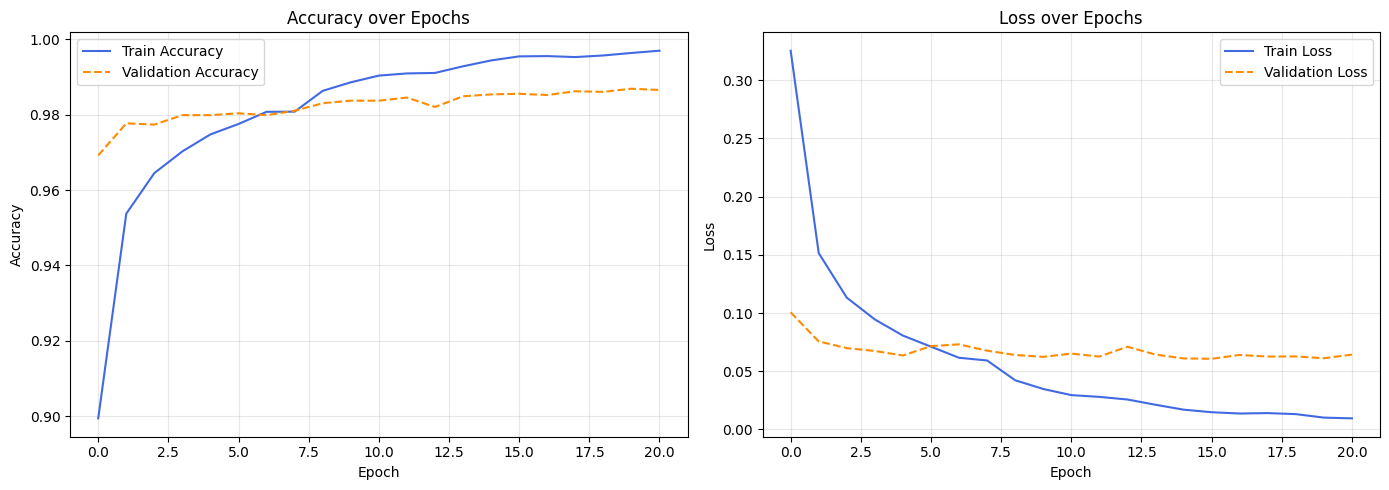

In [7]:
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy
    axes[0].plot(history.history["accuracy"], label="Train Accuracy", color="royalblue")
    axes[0].plot(
        history.history["val_accuracy"],
        label="Validation Accuracy",
        color="darkorange",
        linestyle="--",
    )
    axes[0].set_title("Accuracy over Epochs")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Loss
    axes[1].plot(history.history["loss"], label="Train Loss", color="royalblue")
    axes[1].plot(
        history.history["val_loss"],
        label="Validation Loss",
        color="darkorange",
        linestyle="--",
    )
    axes[1].set_title("Loss over Epochs")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


plot_training_history(history)

## 7. Evaluate on Test Set


In [8]:
test_loss, test_acc = model.evaluate(X_test_flat, y_test_ohe, verbose=0)
print(f"Test Loss     : {test_loss:.4f}")
print(f"Test Accuracy : {test_acc * 100:.2f}%")

Test Loss     : 0.0609
Test Accuracy : 98.43%


## 8. Confusion Matrix


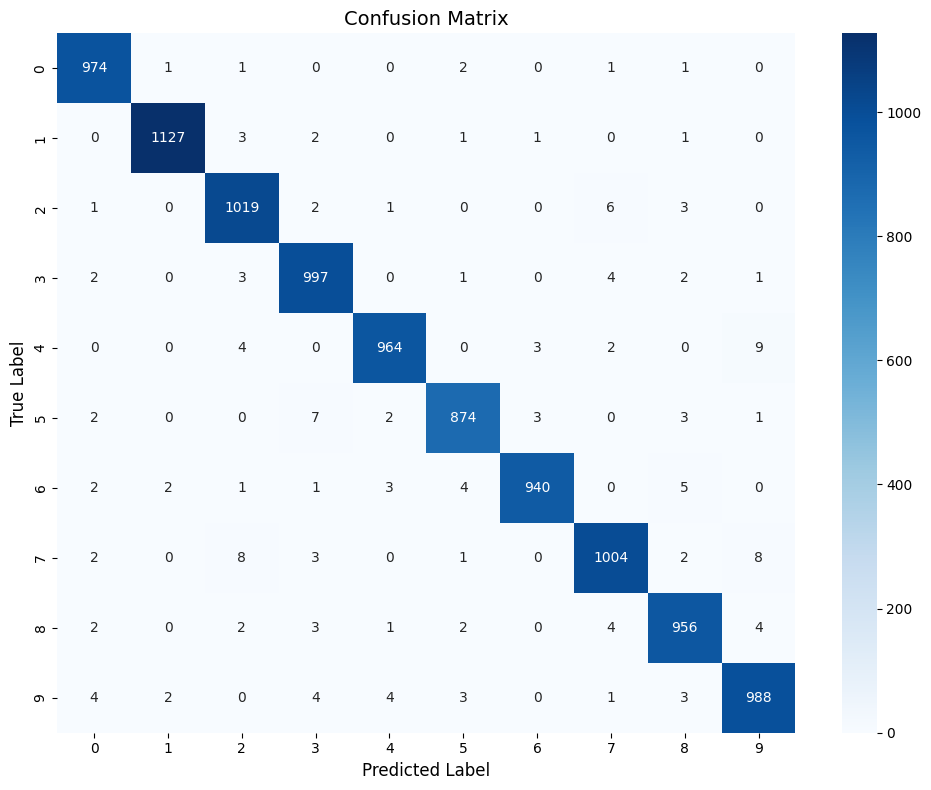

In [9]:
y_pred_probs = model.predict(X_test_flat, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=range(10),
    yticklabels=range(10),
    ax=ax,
)
ax.set_xlabel("Predicted Label", fontsize=12)
ax.set_ylabel("True Label", fontsize=12)
ax.set_title("Confusion Matrix", fontsize=14)
plt.tight_layout()
plt.show()

## 9. Classification Report


In [10]:
print(
    classification_report(
        y_test,
        y_pred,
        target_names=[str(i) for i in range(10)],
    )
)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.99      0.98      0.99       982
           5       0.98      0.98      0.98       892
           6       0.99      0.98      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



## 10. Per-Class Accuracy Bar Chart


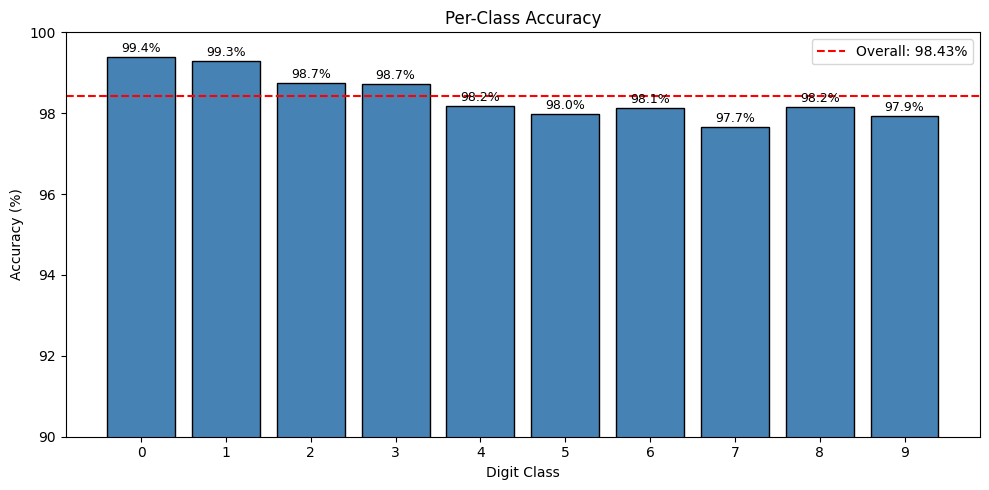

In [11]:
per_class_acc = cm.diagonal() / cm.sum(axis=1)

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(range(10), per_class_acc * 100, color="steelblue", edgecolor="black")
ax.set_xticks(range(10))
ax.set_xticklabels([str(i) for i in range(10)])
ax.set_xlabel("Digit Class")
ax.set_ylabel("Accuracy (%)")
ax.set_title("Per-Class Accuracy")
ax.set_ylim(90, 100)
ax.axhline(
    y=test_acc * 100,
    color="red",
    linestyle="--",
    label=f"Overall: {test_acc * 100:.2f}%",
)
ax.legend()

for bar, acc in zip(bars, per_class_acc):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.05,
        f"{acc * 100:.1f}%",
        ha="center",
        va="bottom",
        fontsize=9,
    )

plt.tight_layout()
plt.show()

## 11. Misclassified Examples


Total misclassified: 157 / 10000


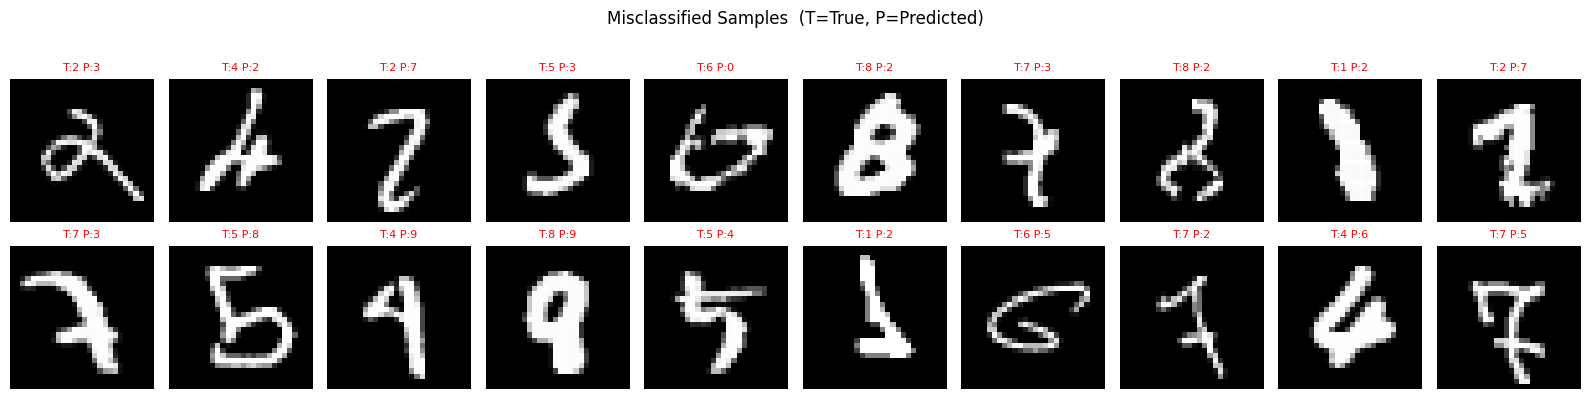

In [12]:
misclassified_idx = np.where(y_pred != y_test)[0]
print(f"Total misclassified: {len(misclassified_idx)} / {len(y_test)}")

# Show first 20 misclassified
n_show = 20
fig, axes = plt.subplots(2, 10, figsize=(16, 4))
for i, idx in enumerate(misclassified_idx[:n_show]):
    row, col = divmod(i, 10)
    axes[row, col].imshow(X_test[idx], cmap="gray")
    axes[row, col].set_title(
        f"T:{y_test[idx]} P:{y_pred[idx]}", fontsize=8, color="red"
    )
    axes[row, col].axis("off")
plt.suptitle("Misclassified Samples  (T=True, P=Predicted)", y=1.02)
plt.tight_layout()
plt.show()

## 12. Prediction Confidence on Random Test Samples


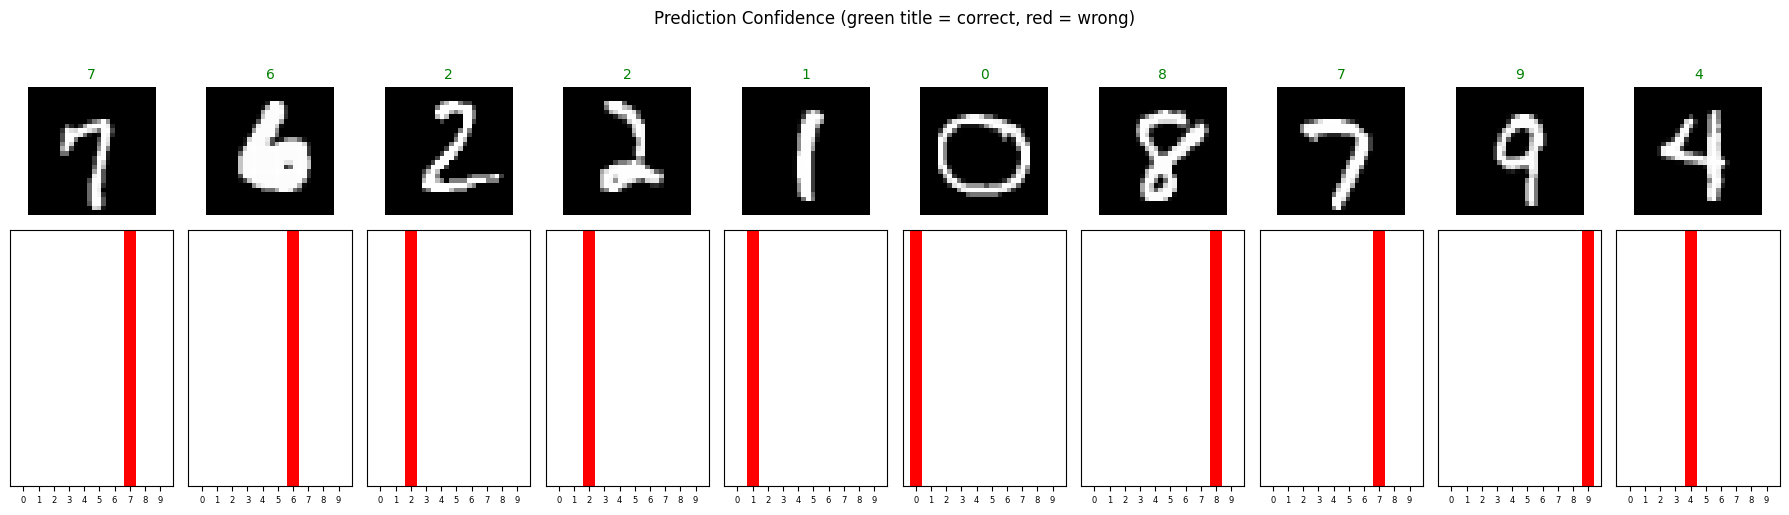

In [13]:
rng = np.random.default_rng(42)
sample_idx = rng.choice(len(X_test), size=10, replace=False)

fig, axes = plt.subplots(2, 10, figsize=(18, 5), gridspec_kw={"height_ratios": [1, 2]})

for col, idx in enumerate(sample_idx):
    # Top row: image
    axes[0, col].imshow(X_test[idx], cmap="gray")
    color = "green" if y_pred[idx] == y_test[idx] else "red"
    axes[0, col].set_title(f"{y_test[idx]}", color=color, fontsize=10)
    axes[0, col].axis("off")

    # Bottom row: confidence bar
    probs = y_pred_probs[idx]
    bar_colors = ["red" if i == y_pred[idx] else "steelblue" for i in range(10)]
    axes[1, col].bar(range(10), probs, color=bar_colors)
    axes[1, col].set_xticks(range(10))
    axes[1, col].set_xticklabels([str(i) for i in range(10)], fontsize=6)
    axes[1, col].set_ylim(0, 1)
    axes[1, col].set_yticks([])

plt.suptitle("Prediction Confidence (green title = correct, red = wrong)", y=1.02)
plt.tight_layout()
plt.show()

## 13. Summary


In [14]:
print("=" * 45)
print("          MODEL SUMMARY")
print("=" * 45)
print(f"  Trainable parameters : {model.count_params():,}")
print(f"  Epochs trained       : {len(history.history['loss'])}")
print(f"  Best val accuracy    : {max(history.history['val_accuracy']) * 100:.2f}%")
print(f"  Test accuracy        : {test_acc * 100:.2f}%")
print(f"  Test loss            : {test_loss:.4f}")
print(f"  Misclassified        : {len(misclassified_idx)} / {len(y_test)}")
print("=" * 45)

          MODEL SUMMARY
  Trainable parameters : 570,506
  Epochs trained       : 21
  Best val accuracy    : 98.68%
  Test accuracy        : 98.43%
  Test loss            : 0.0609
  Misclassified        : 157 / 10000
